In [1]:
import sys

sys.path.append("..")

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

from factors import PriceMomentum, ShortTermReversal, FactorFactor

load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    port=os.getenv("DB_PORT")
)

In [2]:
query = """
SELECT ticker, date, adj_close
FROM daily_prices
ORDER BY ticker, date
"""

prices_long = pd.read_sql(query, conn, parse_dates=["date"])
prices = prices_long.pivot(index="date", columns="ticker", values="adj_close")
print(f"Loaded prices for {len(prices.columns)} stocks, {len(prices)} days")

/var/folders/4d/xhxv9bj17jlcmhb9y9x4_rnh0000gn/T/ipykernel_14783/1487066322.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prices_long = pd.read_sql(query, conn, parse_dates=["date"])


Loaded prices for 100 stocks, 1261 days


In [3]:
# Test 252-day momentum factor

momentum_252 = PriceMomentum(lookback_days=252, skip_days=20)
mom_values = momentum_252.calculate(prices)

print(f"Factor: {momentum_252}")
print(f"Shape: {mom_values.shape}")
print(f"\nLatest momentum values:")
print(mom_values.iloc[-1].sort_values(ascending=False).head(10))

Factor: PriceMomentum(name=momentum_252d), params={'lookback_days': 252, 'skip_days': 20, 'normalize_method': 'zscore', 'winsorize': True}
Shape: (1261, 100)

Latest momentum values:
ticker
APH      2.703594
AMD      2.695477
ALB      2.537517
AMAT     2.344237
CAT      2.057037
GOOGL    2.035585
GOOG     2.000077
CAH      1.973976
CHRW     1.972834
BK       1.731962
Name: 2026-02-13 00:00:00, dtype: float64


In [4]:
# Get top and bottom stocks
top_stocks, bottom_stocks = momentum_252.get_top_bottom_stocks(prices, top_n=10, bottom_n=10)

print("\nTop 10 momentum stocks:")
for ticker, value in top_stocks.items():
    print(f"{ticker:6s}: {value:+.3f}")

print("\nBottom 10 momentum stocks:")
for ticker, value in bottom_stocks.items():
    print(f"{ticker:6s}: {value:+.3f}")


Top 10 momentum stocks:
APH   : +2.704
AMD   : +2.695
ALB   : +2.538
AMAT  : +2.344
CAT   : +2.057
GOOGL : +2.036
GOOG  : +2.000
CAH   : +1.974
CHRW  : +1.973
BK    : +1.732

Bottom 10 momentum stocks:
BRO   : -1.191
CZR   : -1.227
CNC   : -1.286
ADBE  : -1.315
CPB   : -1.343
CDW   : -1.370
BAX   : -1.509
ARE   : -1.686
KMX   : -1.730
CHTR  : -1.732


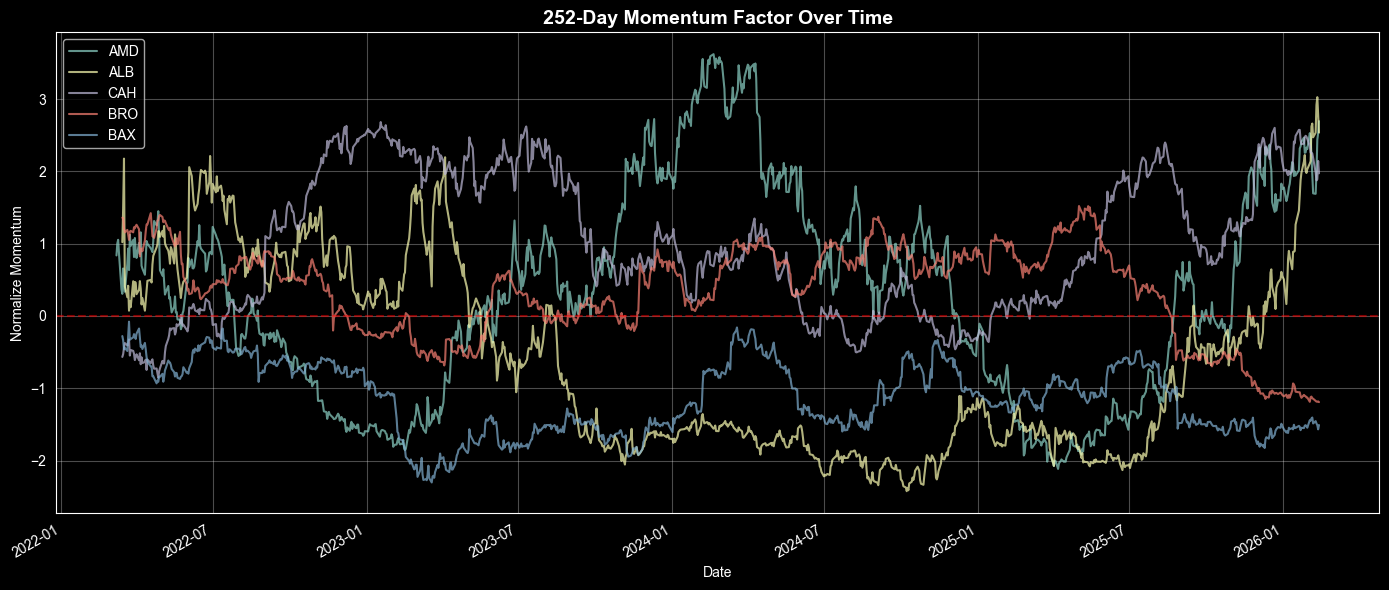

In [5]:
# Visualize factor values over time for a few stocks
fig, ax = plt.subplots(figsize=(14, 6))

sample_tickers = ['AMD', 'ALB', 'CAH', 'BRO', 'BAX']
available_tickers = [t for t in sample_tickers if t in mom_values.columns]

for ticker in available_tickers[:5]:
    mom_values[ticker].plot(ax=ax, label=ticker, alpha=0.7, linewidth=1.5)

ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('252-Day Momentum Factor Over Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalize Momentum')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Test factor factory
print("Testing Factor Factory")
print(f"Available factors: {FactorFactor.list_factors()}")

# Create factors using factory
mom_120 = FactorFactor.create('momentum', lookback_days=120)
reversal = FactorFactor.create('reversal', lookback_days=120)

print(f"Created: {mom_120}")
print(f"Created: {reversal}")

Testing Factor Factory
Available factors: ['momentum', 'reversal']
Created: PriceMomentum(name=momentum_120d), params={'lookback_days': 120, 'skip_days': 20, 'normalize_method': 'zscore', 'winsorize': True}
Created: ShortTermReversal(name=reversal_120d), params={'lookback_days': 120, 'normalize_method': 'zscore'}


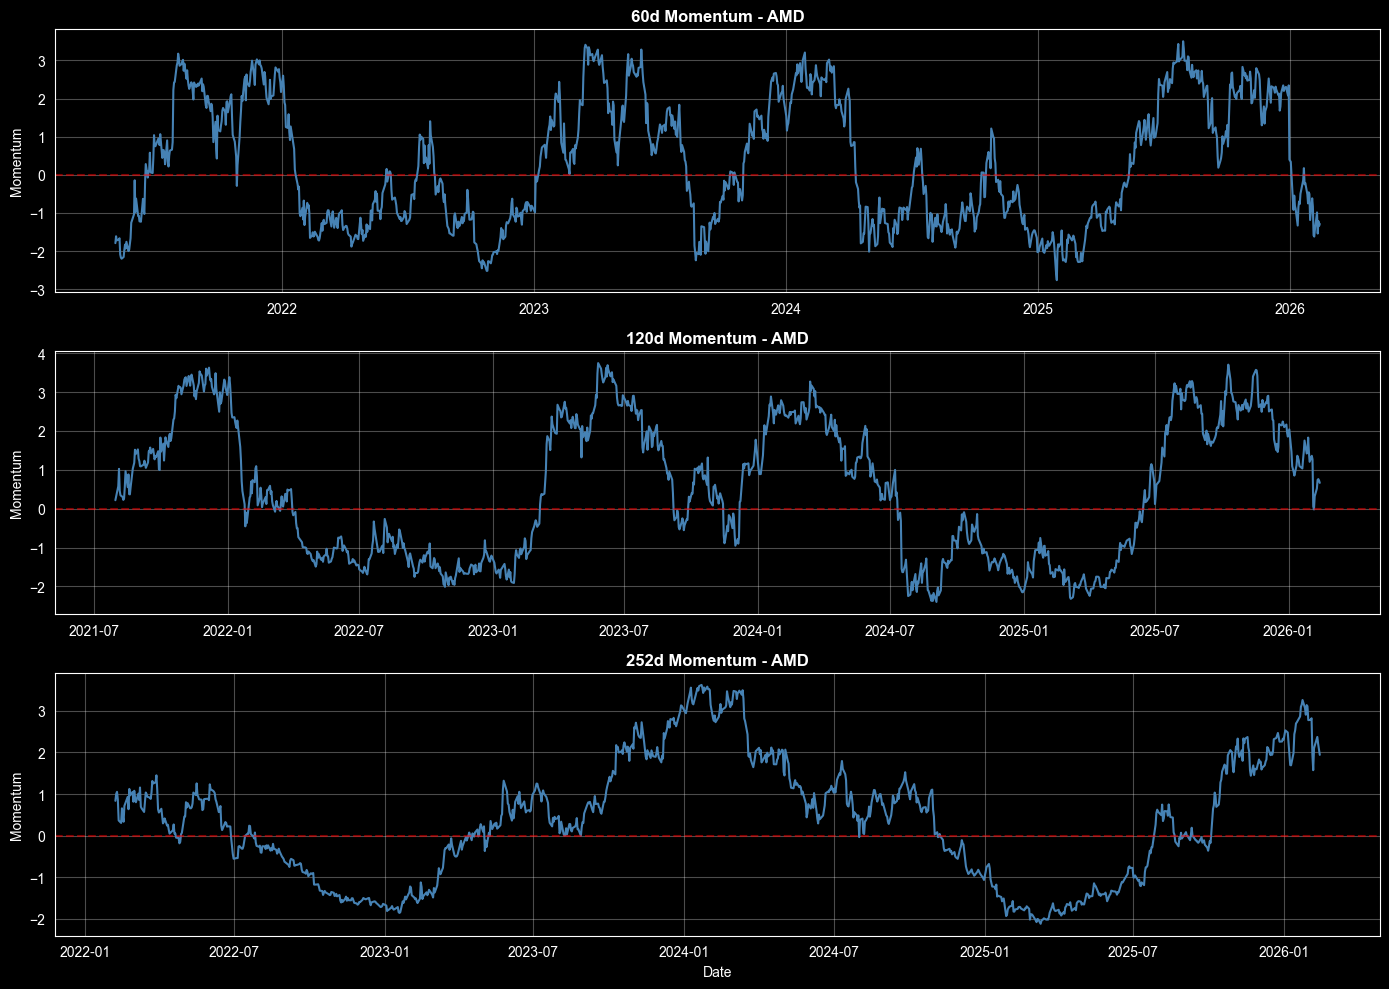

In [7]:
# Compare multiple momentum periods
periods = [60, 120, 252]
momentum_factors = {}

for period in periods:
    factor = PriceMomentum(lookback_days=period, skip_days=0)
    momentum_factors[f'{period}d'] = factor.calculate(prices)

# Plot comparison
fig, axes = plt.subplots(len(periods), 1, figsize=(14, 10))

for i, (name, values) in enumerate(momentum_factors.items()):
    ticker = 'AMD' if 'AMD' in values.columns else values.columns[0]

    axes[i].plot(values.index, values[ticker], linewidth=1.5, color='steelblue')
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i].set_title(f'{name} Momentum - {ticker}', fontweight='bold')
    axes[i].set_ylabel('Momentum')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [8]:
# Factor performance check
forward_returns = prices.pct_change(periods=60).shift(-60)

# Calculate IC for 252-day momentum
correlations = []
dates = []

for date in mom_values.index[252:-60]:
    mom = mom_values.loc[date].dropna()
    fwd = forward_returns.loc[date].dropna()
    common = mom.index.intersection(fwd.index)

    if len(common) > 5:
        corr = mom[common].corr(fwd[common])
        if not np.isnan(corr):
            correlations.append(corr)
            dates.append(date)

ic_mean = np.mean(correlations)
print("252-Day Momentum Factor Performance:")
print(f"IC Mean: {ic_mean:.4f}")
print(f"Factor system working correctly" if ic_mean > 0.02 else "Check factor implementation")

252-Day Momentum Factor Performance:
IC Mean: 0.0226
Factor system working correctly
